## Imports and Functions

In [2]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import regex as re
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
zip_path = "/content/drive/MyDrive/Felix/code/AgeRecognition/raw_data/UTKFace.zip"

!mkdir UTKFaces

%cd UTKFaces

!cp "{zip_path}" .

!unzip -q UTKFace.zip

!rm UTKFace.zip

/content/UTKFaces/UTKFaces


In [6]:
#folder_path = '/Users/Felix/Google Drive/Felix/code/AgeRecognition/raw_data/Faces'
folder_path = '/content/UTKFaces/UTKFaces/Faces'

In [7]:
def load_images_from_folder(folder_path):
    filenames = [f for f in os.listdir(folder_path) if not f.startswith('.')]
    filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
    images = []
    for filename in filenames:
        if filename.startswith('81'):
            break
        img_cv = cv2.imread(os.path.join(folder_path,filename))
        if img_cv is not None:
            img = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
            images.append(img)
    return images

def show_all_images_from_list(img_list,img_df):
    n=int(len(img_list)/5) +1 
    f = plt.figure(figsize=(25,n*5))
    for i,img in enumerate(img_list):
        f.add_subplot(n, 5, i + 1)
        plt.title(f'{img_df.iloc[i]}',
                  fontweight="bold",
                  fontsize=15)
        plt.imshow(img)
        f.tight_layout()

def load_image_data_into_dataframe(folderpath):

    filenames = [f for f in os.listdir(folder_path) if not f.startswith('.')]
    filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
    df = pd.DataFrame()
    for filename in filenames:
        if filename.startswith('81'):
            break
        parsed_name = filename.split('_')
        df= df.append({'age' : int(parsed_name[0]),
                       'gender' : parsed_name[1],
                       'race' : parsed_name[2]}, ignore_index=True)
    df['gender'] = df['gender'].map({'0': 'male', '1': 'female'})
    df['race'] = df['race'].map({'0': 'White', '1': 'Black', '2': 'Asian', '3': 'Indian', '4': 'Others'})
    return df

In [8]:
img_pic=load_images_from_folder(folder_path)

In [9]:
len(img_pic)

22005

In [10]:
img_df = load_image_data_into_dataframe(folder_path)

## Visualizations

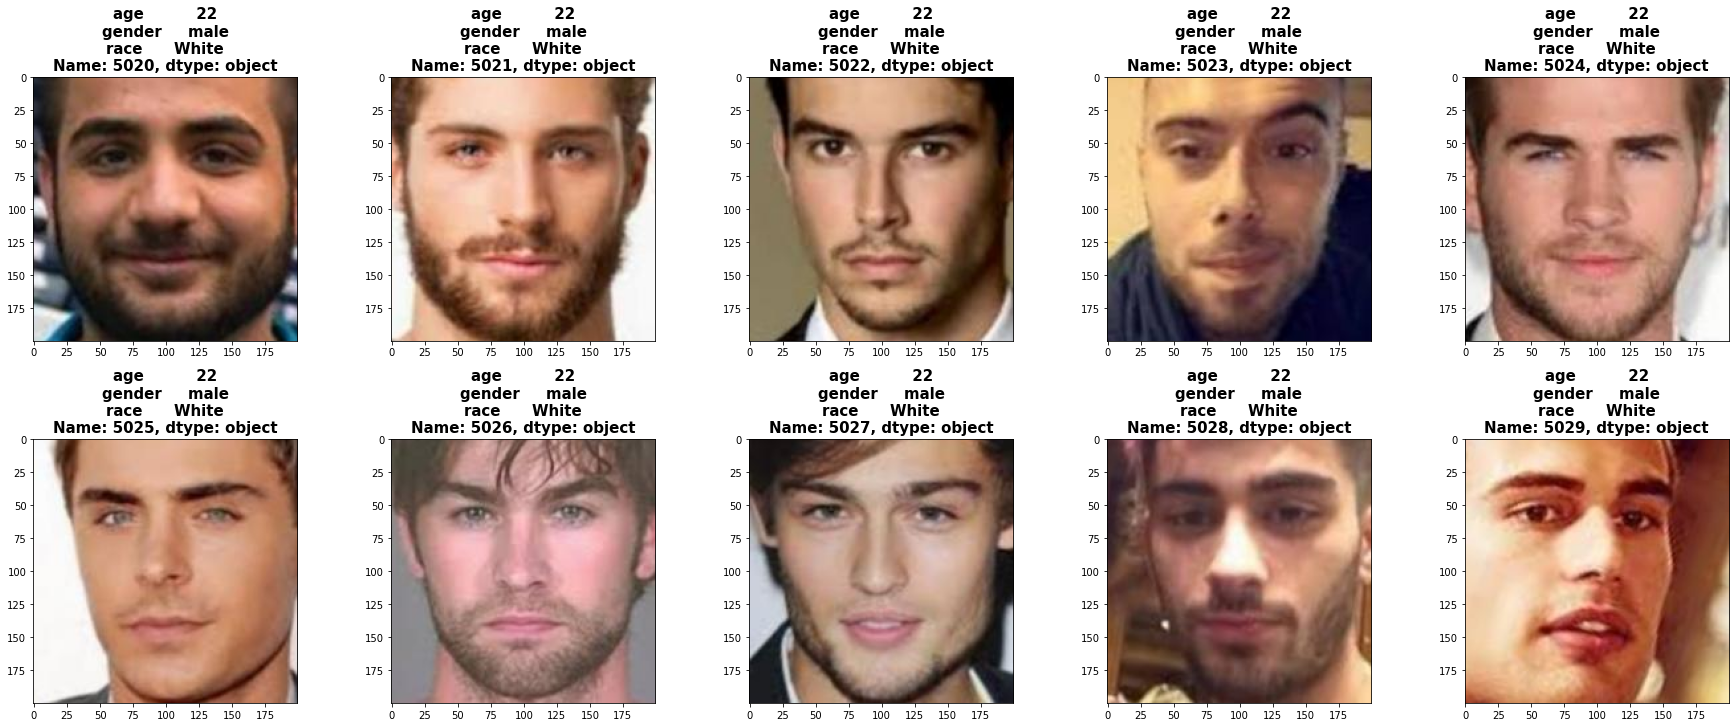

In [9]:
show_all_images_from_list(img_pic[5020:5030],img_df[5020:5030])

In [10]:
img_df.shape

(22005, 3)

In [11]:
img_df.iloc[0]

age           1
gender     male
race      White
Name: 0, dtype: object

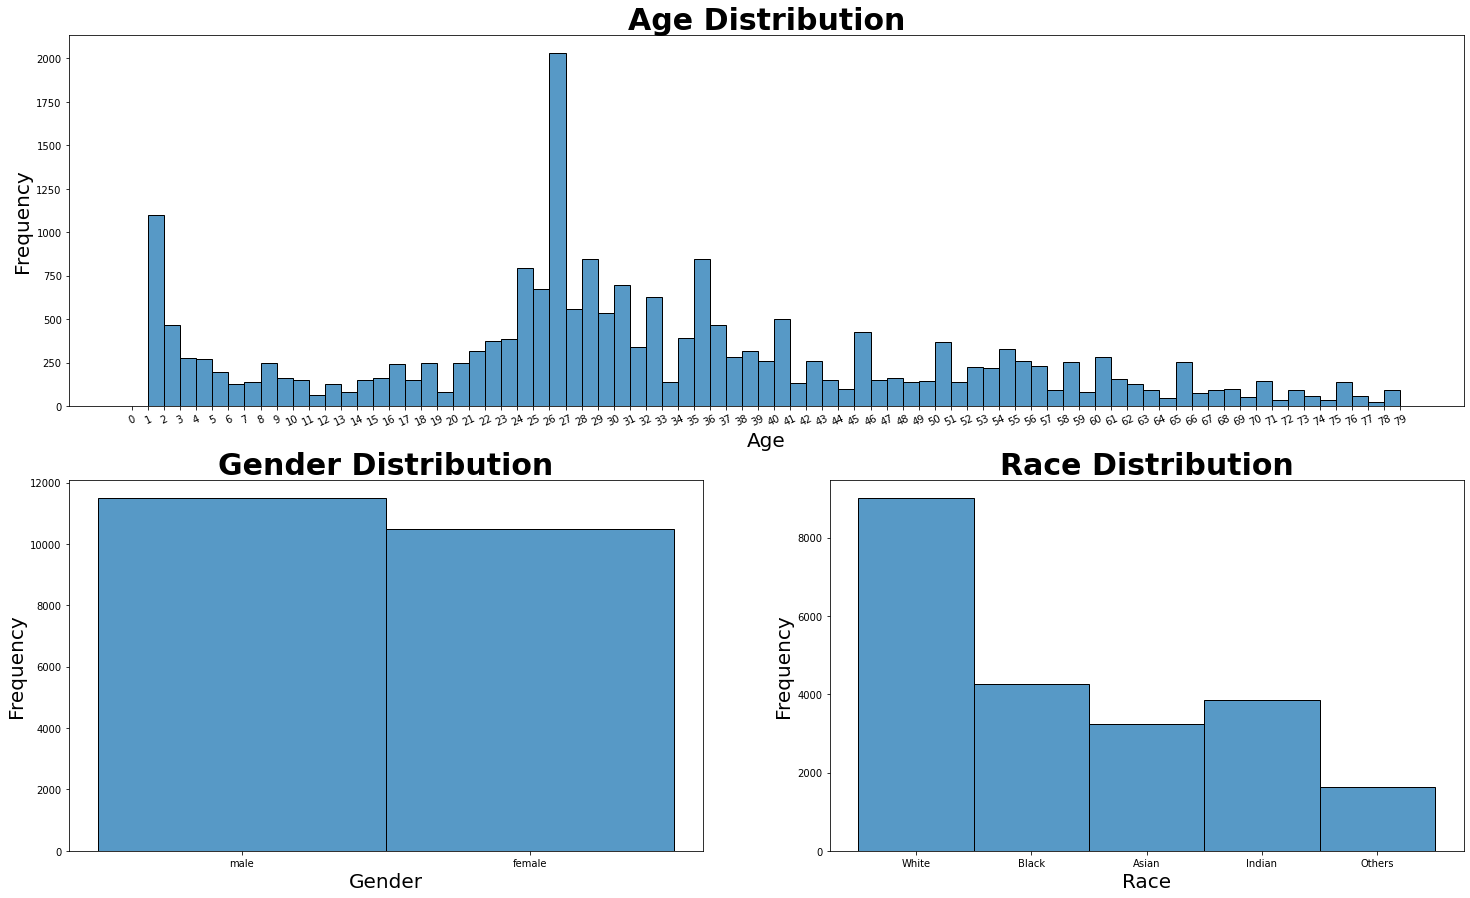

In [12]:
f = plt.figure(figsize=(25,15))
#bins_value=[1,5,19,25,28,32,39,49,58,80]
#bins_value = [0,5,10,15,20,25,27,30,35,40,45,50,55,60,65,70,75,80]
bins_value = list(range(0,80,1))

#Age Histogram
f.add_subplot(211)
sns.histplot(data=img_df,x = 'age', bins=bins_value)
plt.title('Age Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Age',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(bins_value, rotation = 25)

# Gender Histogram
f.add_subplot(223)
sns.histplot(img_df['gender'])
plt.title('Gender Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Gender',fontsize=20)
plt.ylabel('Frequency',fontsize=20)

#Race Histogram
f.add_subplot(224)
sns.histplot(img_df['race'])
plt.title('Race Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Race',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks()

plt.show()

## Targets into Age Bins

In [11]:
a=pd.qcut(img_df['age'],10)

In [12]:
a.value_counts().sort_index()

(0.999, 5.0]    2308
(5.0, 19.0]     2120
(19.0, 25.0]    2795
(25.0, 26.0]    2031
(26.0, 29.0]    1938
(29.0, 34.0]    2193
(34.0, 39.0]    2168
(39.0, 49.0]    2165
(49.0, 58.0]    2124
(58.0, 80.0]    2163
Name: age, dtype: int64

In [13]:
img_df['age_group'] = pd.qcut(img_df['age'],10)

In [14]:
img_df

,age,gender,race,age_group
0,1.0,male,White,"(0.999, 5.0]"
1,1.0,male,White,"(0.999, 5.0]"
2,1.0,male,White,"(0.999, 5.0]"
3,1.0,male,White,"(0.999, 5.0]"
4,1.0,male,White,"(0.999, 5.0]"
...,...,...,...,...
22000,80.0,female,Black,"(58.0, 80.0]"
22001,80.0,female,Asian,"(58.0, 80.0]"
22002,80.0,female,Asian,"(58.0, 80.0]"
22003,80.0,female,Indian,"(58.0, 80.0]"


In [15]:
img_df['age_group'].unique()

[(0.999, 5.0], (5.0, 19.0], (19.0, 25.0], (25.0, 26.0], (26.0, 29.0], (29.0, 34.0], (34.0, 39.0], (39.0, 49.0], (49.0, 58.0], (58.0, 80.0]]
Categories (10, interval[float64]): [(0.999, 5.0] < (5.0, 19.0] < (19.0, 25.0] < (25.0, 26.0] < ... <
                                     (34.0, 39.0] < (39.0, 49.0] < (49.0, 58.0] < (58.0, 80.0]]

## PCA (doesn't work)

#### Sample

In [21]:
n=2000
img_pic_sample = random.sample(img_pic, n)
img_array = np.array(img_pic_sample)
img_array.shape

(2000, 200, 200, 3)

#### Flatten

In [22]:
img_array_flat = img_array.reshape(n,120000)
img_array_flat.shape

(2000, 120000)

#### Compress

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
data_projected = pca.fit_transform(img_array_flat)
data_projected.shape

(2000, 200)

In [24]:
data_reconstructed = pca.inverse_transform(data_projected)
data_reconstructed.shape

(2000, 120000)

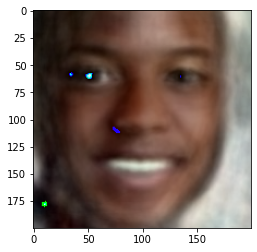

In [25]:
plt.imshow((data_reconstructed[12].reshape((200,200,3))).astype(np.uint8))

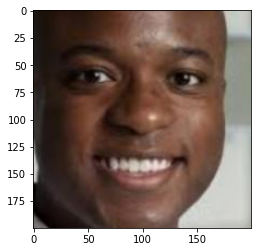

In [26]:
plt.imshow(img_pic_sample[12])

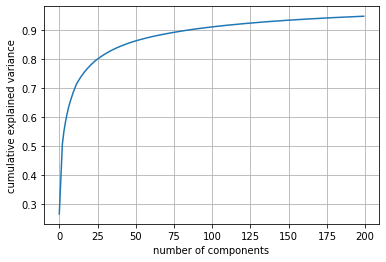

In [27]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

## CNN

In [23]:
X = img_pic
y = img_df['age_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
X_train = np.array(X_train)
X_test =np.array(X_test)
X_train.shape

(14743, 200, 200, 3)

In [ ]:
X_train = X_train/255 - 0.5
X_test = X_test/255 - 0.5

In [19]:
X_train.shape

AttributeError: ignored

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)